# Context relevancy with Ragas

This notebook shows you how to validate changes on your RAG application against context relevancy.  
We rely on Ragas to evaluate that metric, to then visualize our iterative experiments in Literal. 

First, we create a dataset from an example RAG application. Second, we evaluate the impact of a retrieval parameter change (# of contexts) on context relevancy: 
- [Run a RAG application](#run-rag-app)
- [Create a Dataset](#create-dataset)
- [Experiment A &ndash; # contexts = 2](#experiment-a)
    - Evaluate with Ragas
    - Persist experiment to Literal
- [Experiment B &ndash; # contexts = 1](#experiment-b)
    - Evaluate with Ragas
    - Persist experiment to Literal


<a id="run-rag-app"></a>
## Run a RAG application

### Create a Chroma vector database

In [1]:
import chromadb

chroma_client = chromadb.Client()

collection = chroma_client.get_or_create_collection("Biography")
collection.add(
    documents=["My name is John.", "My job is coding.", "My dog's name is Fido. Fido is an expert fetcher."],
    ids=["id1", "id2", "id3"]
)

### Import the Literal SDK

In [2]:
import os

from openai import OpenAI
from dotenv import load_dotenv
from literalai import LiteralClient

load_dotenv()

openai_client = OpenAI()

literal_client = LiteralClient()
literal_client.instrument_openai()

### Create a prompt

In [3]:
PROMPT_NAME = "RAG prompt"
template_messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that always answers questions. Keep it short, and if available prefer responding with code."
    },
    {
        "role": "user",
        "content": "Answer the question based on the context below.\nContext:\n{{#context}}\n{{.}}\n{{/context}}\nQuestion:\n{{question}}\nAnswer:"
    }
]

prompt = literal_client.api.create_prompt(name=PROMPT_NAME, template_messages=template_messages)

### Ask questions to RAG application

In [4]:
@literal_client.step(type="run", name="RAG")
def rag(user_query: str):
    with literal_client.step(type="retrieval", name="Retrieve") as step:
        step.input = { "question": user_query }
        results = collection.query(query_texts=[user_query], n_results=2)
        step.output = results

    messages = prompt.format({"context": results["documents"][0], "question": user_query})
    
    completion = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
    )

    return completion.choices[0].message.content
        
def main():
    questions = [ "What's my name?", "What's my job?" ]
    for idx, question in enumerate(questions):
        with literal_client.thread(name=f"Question {idx+1}") as thread:
            literal_client.message(content=question, type="user_message", name="User")
            answer = rag(question)
            literal_client.message(content=answer, type="assistant_message", name="My Assistant")

main()

# Network requests by the SDK are performed asynchronously.
# Invoke flush() to guarantee the completion of all requests prior to the process termination.
# WARNING: If you run a continuous server, you should not use this method.
literal_client.flush()

<a id="create-dataset"></a>
## Create a Dataset

In [5]:
DATASET_NAME = f"Biography Evaluation Dataset"

dataset = literal_client.api.get_dataset(name=DATASET_NAME)

In [6]:
if not dataset:
    dataset = literal_client.api.create_dataset(name=DATASET_NAME)
    
    threads = literal_client.api.get_threads(first=2).data
    
    rag_steps = []
    for thread in threads:
        rag_steps.extend([step for step in thread.steps if step.name == "RAG"])
    
    for step in rag_steps:
        dataset.add_step(step.id)

<a id="experiment-a"></a>
## Experiment A - # contexts = 2

### Evaluate with Ragas

#### Prepare Ragas data samples

In [7]:
import json

from literalai import DatasetItem
from typing import List

items = dataset.items

# Get the retrieved contexts for each question.
contexts = []
for item in items:
    retrieve_step = next(step for step in item.intermediary_steps if step["name"] == "Retrieve")
    contexts.append(retrieve_step["expectedOutput"]["documents"][0])

# Data samples, in the format expected by Ragas. No ground truth needed since we will evaluate context relevancy.
data_samples = {
    'question': [item.input["args"][0] for item in items],
    'answer': [item.expected_output["content"] for item in items],
    'contexts': contexts,
    'ground_truth': [""]* len(items)
}

#### Run the evaluation

We will evaluate context relevancy which checks how relevant the retrieved contexts are to answer the user's question. 

The more unneeded details in the contexts, the less relevant (between 0 and 1, 0 being least relevant).

In [8]:
from datasets import Dataset

from ragas import evaluate
from ragas.metrics import context_relevancy

results = evaluate(Dataset.from_dict(data_samples), metrics=[context_relevancy]).to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

### Persist experiment to Literal

In [9]:
experiment = dataset.create_experiment(
    name="Biography - Experiment A",
    prompt_id=prompt.id,
    params=[{ "type": context_relevancy.name, "top_k": 2 }]
)

# Log each experiment result.
for index, row in results.iterrows():
    scores = [{ 
        "name": context_relevancy.name,
        "type": "AI",
        "value": row[context_relevancy.name]
    }]

    experiment_item = {
        "datasetItemId": items[index].id,
        "scores": scores,
        "input": { "question": row["question"] },
        "output": { "contexts": row["contexts"].tolist() }
    }
    
    experiment.log(experiment_item)

<a id="experiment-b"></a>
## Experiment B - # contexts = 1

### Evaluate with Ragas

We evaluate with the first context only to see how context relevancy gets impacted.

In [10]:
data_samples["contexts"] = [x[:1] for x in contexts]

results = evaluate(Dataset.from_dict(data_samples), metrics=[context_relevancy]).to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

### Persist experiment to Literal

In [11]:
experiment = dataset.create_experiment(
    name="Biography - Experiment B",
    prompt_id=prompt.id,
    params=[{ "type": context_relevancy.name, "top_k": 1 }]
)

# Log each experiment result.
for index, row in results.iterrows():
    scores = [{ 
        "name": context_relevancy.name,
        "type": "AI",
        "value": row[context_relevancy.name]
    }]

    experiment_item = {
        "datasetItemId": items[index].id,
        "scores": scores,
        "input": { "question": row["question"] },
        "output": { "contexts": row["contexts"].tolist() }
    }
    
    experiment.log(experiment_item)

## Visualize from Literal Experiments !

Comparing both experiments from Literal, one can visualize the diff in retrieved contexts, two for experiment A versus one for experiment B. 

Context relevancy captures the ratio of question-relevant facts in retrieved contexts.  

When we retrieve irrelevant contexts (the two facts about the dog do not help towards answering the question), context relevancy is 1/3.  
Once we limit ourselves to a single context, we retrieve exactly the one useful fact, which yields a maximum context relevancy of 1. 

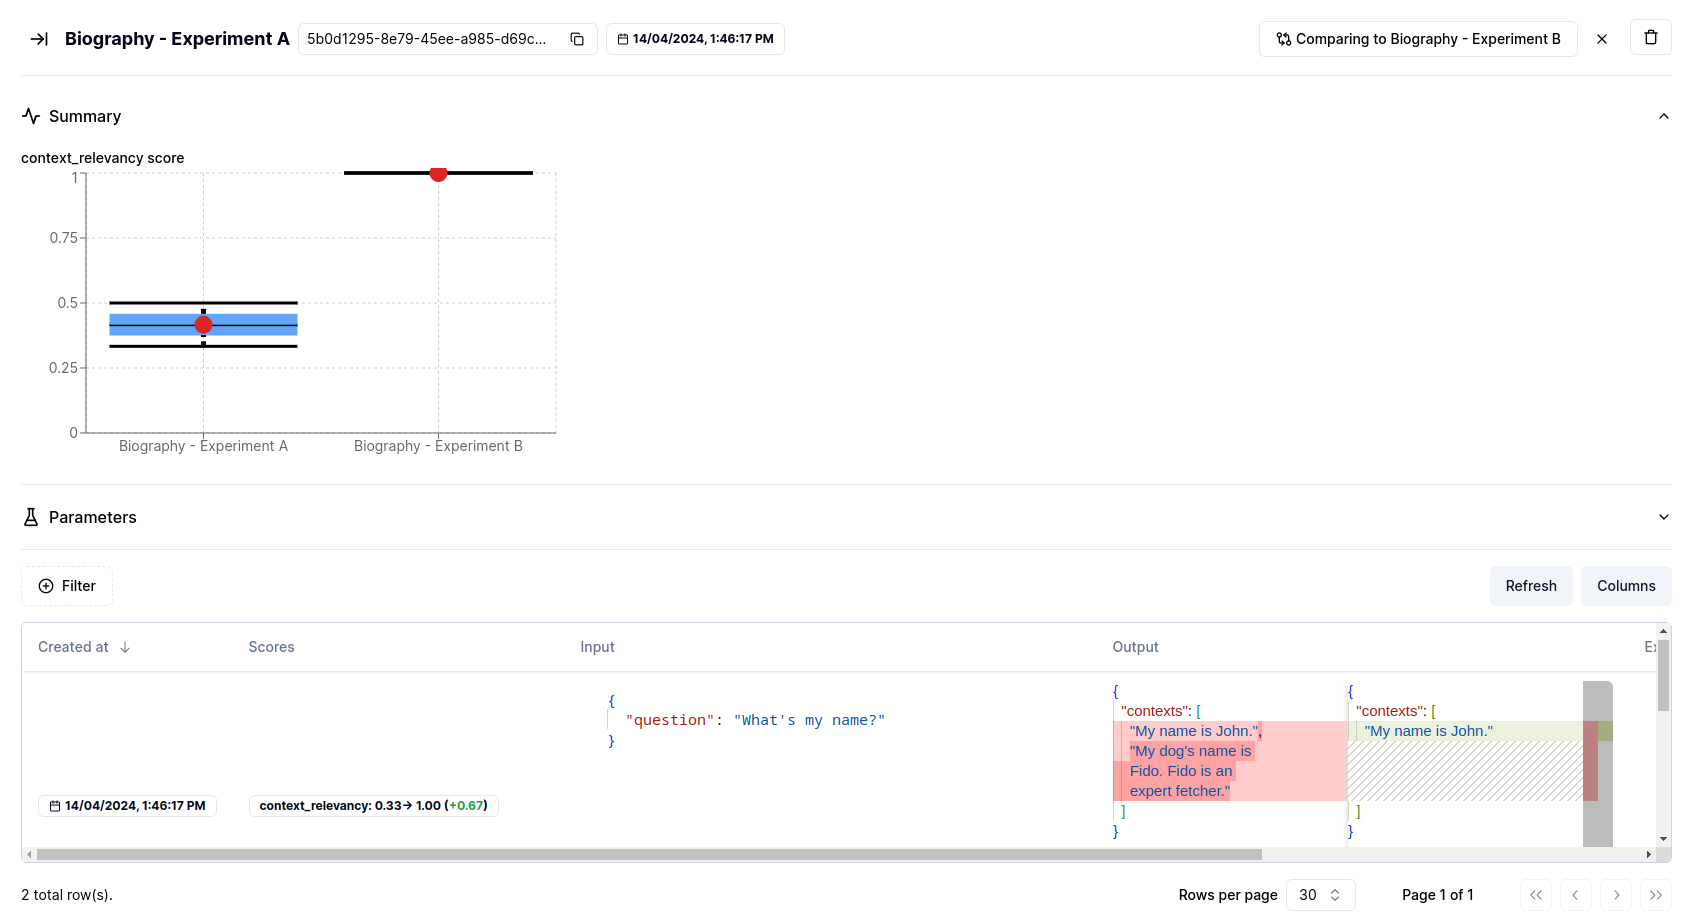